In [1]:
import pseudo_R2
import pandas as pd
import numpy as np

import scipy.optimize
import scipy.stats as stats


In [2]:
def calc_pR2(sites, mutations, rates, distribution = None, polymorphism = True):
    bin_p = sites / np.sum(sites)

    # Use a Poisson link to scale rates to the probability of observing a mutation
    # This is relevant if analyzing population data where recurrent mutation is likely
    
    if polymorphism:    
        def poisson_link(x):
            return -np.sum(stats.binom.logpmf(k=mutations,
                                              n=sites,
                                              p=(1 - np.exp(-x * rates))))
        # Find a non-awful starting place for optimization
        # Replace with ML estimate at some point
        x0 = np.array([-np.log(0.99) / np.max(rates)])
        scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                              options={'xatol': 1e-3, 'disp': False})
        scaling_factor = scaling_fit.x[0]

        mut_p = 1 - np.exp(-scaling_factor * rates)
    else:
        def poisson_link(x):
            return -np.sum(stats.binom.logpmf(k=mutations,
                                              n=sites,
                                              p=x * rates))
        # Find a non-awful starting place for optimization
        # Replace with ML estimate at some point
        x0 = np.array([-np.log(0.99) / np.max(rates)])
        scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                              options={'xatol': 1e-3, 'disp': False})
        scaling_factor = scaling_fit.x[0]

        mut_p = scaling_factor * rates
            
    # Calculate pseudo-R2 for the observed data
    if distribution is None:
        e_ll = pseudo_R2.exp_likelihood_model(mut_p, bin_p)
        e_ll_null = pseudo_R2.exp_likelihood_null(mut_p, bin_p)
    else:
        sites_d = distribution[0]
        mutations_d = distribution[1]
        rates_d = distribution[2]
        
        bin_p_d = sites_d / np.sum(sites_d)

        
        if polymorphism:    
            def poisson_link(x):
                return -np.sum(stats.binom.logpmf(k=mutations_d,
                                                  n=sites_d,
                                                  p=(1 - np.exp(-x * rates_d))))
            # Find a non-awful starting place for optimization
            # Replace with ML estimate at some point
            x0 = np.array([-np.log(0.99) / np.max(rates_d)])
            scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                                  options={'xatol': 1e-3, 'disp': False})
            scaling_factor = scaling_fit.x[0]

            mut_p_distribution = 1 - np.exp(-scaling_factor * rates_d)
        
        else:
            def poisson_link(x):
                return -np.sum(stats.binom.logpmf(k=mutations_d,
                                                  n=sites_d,
                                                  p=x * rates_d))
            # Find a non-awful starting place for optimization
            # Replace with ML estimate at some point
            x0 = np.array([-np.log(0.99) / np.max(rates_d)])
            scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                                  options={'xatol': 1e-3, 'disp': False})
            scaling_factor = scaling_fit.x[0]

            mut_p_distribution = scaling_factor * rates_d
        
        e_ll = pseudo_R2.exp_likelihood_model(mut_p_distribution, bin_p_d)
        e_ll_null = pseudo_R2.exp_likelihood_null(mut_p_distribution, bin_p_d)
        
    a_ll = pseudo_R2.avg_likelihood_sample(sites, mutations, mut_p)
#     a_ll_null = pseudo_R2.null_likelihood_sample(sites, mutations, mut_p, bin_p)

    
    max_R2 = pseudo_R2.calculate_R2(e_ll, e_ll_null)
    R2 = pseudo_R2.calculate_R2(a_ll, e_ll_null)
    pR2 = R2 / max_R2
    return max_R2, R2, pR2

In [3]:
mu_list = ["mu", "Carlson_rate", "gnomAD_rate"]

In [8]:
def run_pR2_sampling_persite(polymorphic):
    n_bootstrap = 1000

    max_R2_s_s = []
    R2_s_s = []
    pR2_s_s = []


    for i in range(n_bootstrap):

#         print(i)

        df_carlson = pd.read_csv("data/sample_sites/"+ polymorphic + "_Carlson_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
        df_gnomad = pd.read_csv("data/sample_sites/" + polymorphic + "_gnomAD_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
        df_roulette = pd.read_csv("data/sample_sites/" + polymorphic + "_mu_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1, 2])

        df_list = [df_roulette, df_carlson, df_gnomad]

        for df in df_list:
            df.columns = ["rate", "sites", "mutations"]

        distribution = [df_roulette["sites"].to_numpy(dtype=int), df_roulette["mutations"].to_numpy(dtype=int),df_roulette["rate"].to_numpy(dtype=float)]

        max_R2_s = []
        R2_s = []
        pR2_s = []

        for df in df_list:
            rates = df["rate"].to_numpy(dtype=float)
            sites = df["sites"].to_numpy(dtype=int)
            mutations = df["mutations"].to_numpy(dtype=int)

            max_R2, R2, pR2 = calc_pR2(sites, mutations, rates, distribution)

            max_R2_s.append(max_R2)
            R2_s.append(R2)
            pR2_s.append(pR2)

        max_R2_s_s.append(max_R2_s)
        R2_s_s.append(R2_s)
        pR2_s_s.append(pR2_s)
        
    df_summary = pd.DataFrame(pR2_s_s, columns = ["Roulette", "Carlson", "gnomAD"])

    df_summary["Roulette - Carlson"] = df_summary["Roulette"] - df_summary["Carlson"]
    df_summary["Roulette - gnomAD"] = df_summary["Roulette"] - df_summary["gnomAD"]

    df_summary.to_csv(polymorphic + "_pR2_1000.tsv", sep = "\t", index = None)
    
    return df_summary

## perform for polymorphic gnomADv2

In [9]:
df_summary_gnomADv2_polymorphic = run_pR2_sampling_persite("gnomADv2_polymorphic")

In [10]:
df_summary_gnomADv2_polymorphic.quantile([.025, .5, 0.975])

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0.025,0.857489,0.811209,0.780278,0.045524,0.076372
0.500,0.860518,0.813989,0.783266,0.046531,0.077256
0.975,0.863303,0.816626,0.785855,0.047551,0.078109


## calculate for denovo combined

In [12]:
df_summary_denovo_combined = run_pR2_sampling_persite("denovo_combined")

In [13]:
df_summary_denovo_combined.quantile([.025, .5, 0.975])

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0.025,0.853927,0.805512,0.782466,0.033431,0.053340
0.500,0.926147,0.870619,0.854193,0.054275,0.071409
0.975,0.994460,0.932114,0.919962,0.074767,0.088129


## calculate for ukb

In [14]:
df_summary_ukb_polymorphic = run_pR2_sampling_persite("ukb_polymorphic")

In [15]:
df_summary_ukb_polymorphic.quantile([.025, .5, 0.975])

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0.025,0.874208,0.823044,0.795101,0.050295,0.078375
0.500,0.877261,0.825886,0.798000,0.051350,0.079273
0.975,0.880298,0.828599,0.800843,0.052449,0.080228


## generate 2a

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", palette=None, font_scale=2)
sns.despine(bottom = True, left = True)

<Figure size 640x480 with 0 Axes>

In [5]:
df_summary_ukb_polymorphic = pd.read_csv("ukb_polymorphic_pR2_1000.tsv", sep = "\t")
df_summary_gnomadv2_polymorphic = pd.read_csv("gnomADv2_polymorphic_pR2_1000.tsv", sep = "\t")
df_summary_denovo_combined = pd.read_csv("denovo_combined_pR2_1000.tsv", sep = "\t")
# df_summary_denovo_exome = pd.read_csv("denovo_exome_pR2_1000.tsv", sep = "\t")

In [6]:
df_summary_ukb_polymorphic

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0,0.875413,0.824779,0.796596,0.050634,0.078817
1,0.878369,0.827236,0.799021,0.051133,0.079349
2,0.875698,0.823938,0.796072,0.051759,0.079626
3,0.874995,0.823815,0.795875,0.051180,0.079120
4,0.877552,0.826553,0.798470,0.050999,0.079081
...,...,...,...,...,...
995,0.879963,0.828946,0.799768,0.051017,0.080195
996,0.875299,0.825015,0.796303,0.050284,0.078995
997,0.877464,0.826342,0.797736,0.051122,0.079728
998,0.879882,0.828443,0.799887,0.051438,0.079995


In [7]:
df_summary_list = [df_summary_ukb_polymorphic, df_summary_gnomadv2_polymorphic, df_summary_denovo_combined]

In [8]:
dataset = ["UkBiobank", "gnomADv2", "denovo"]

i = 0
for df_summary in df_summary_list:
    df_melt_pr2 = pd.melt(df_summary[["Roulette", "Carlson", "gnomAD"]], 
        value_vars=['Roulette', 'Carlson', 'gnomAD'], var_name="Model", value_name='pR2')
    
    df_melt_pr2["Dataset"] = dataset[i]
    
    if i == 0:
        df_melt_combined_pr2 = df_melt_pr2
    else:
        df_melt_combined_pr2 = pd.concat([df_melt_combined_pr2, df_melt_pr2])
        
    i += 1

In [9]:
df_melt_combined_pr2["1-pR2"] = 1 - df_melt_combined_pr2["pR2"]

In [10]:
df_melt_combined_pr2 = df_melt_combined_pr2.replace("UkBiobank", "UKBiobank")
df_melt_combined_pr2 = df_melt_combined_pr2.replace("denovo", "de novo")

In [14]:
df_melt_combined_pr2

,Model,pR2,Dataset,1-pR2
0,Roulette,0.875413,UKBiobank,0.124587
1,Roulette,0.878369,UKBiobank,0.121631
2,Roulette,0.875698,UKBiobank,0.124302
3,Roulette,0.874995,UKBiobank,0.125005
4,Roulette,0.877552,UKBiobank,0.122448
...,...,...,...,...
2995,gnomAD,0.856310,de novo,0.143690
2996,gnomAD,0.835348,de novo,0.164652
2997,gnomAD,0.858727,de novo,0.141273
2998,gnomAD,0.905216,de novo,0.094784


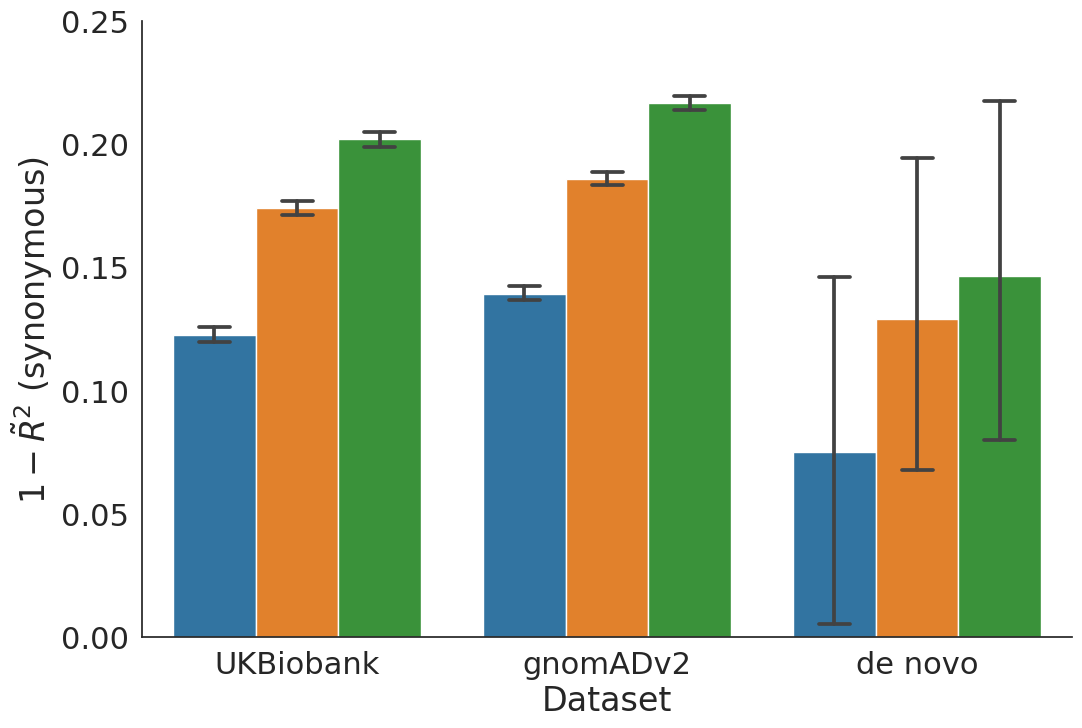

In [31]:
plt.subplots(figsize=(12, 8))
# ax = sns.pointplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model", errorbar=('pi', 95))
ax = sns.barplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model", errorbar=('pi', 95), capsize = 0.1)
# ax = sns.barplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0.00, 0.25)
# plt.legend(loc='upper right')
ax.set_ylabel(r"$1-\tilde{R}^2$ (synonymous)")
ax.get_legend().remove()

plt.savefig("2a.pdf", format="pdf", bbox_inches="tight")

# for container in ax.containers:
#     ax.bar_label(container)


<BarContainer object of 3 artists>
<BarContainer object of 3 artists>
<BarContainer object of 3 artists>


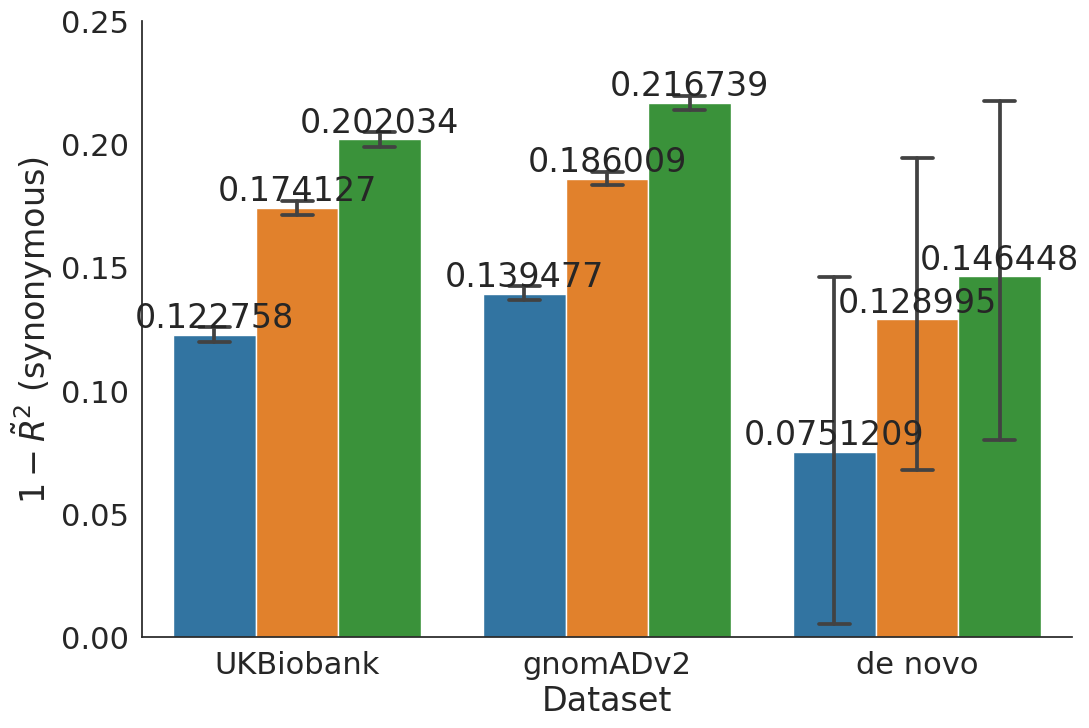

In [29]:
plt.subplots(figsize=(12, 8))
# ax = sns.pointplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model", errorbar=('pi', 95))
ax = sns.barplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model", errorbar=('pi', 95), capsize = 0.1)
# ax = sns.barplot(df_melt_combined_pr2, y="1-pR2", x="Dataset", hue="Model")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0.00, 0.25)
# plt.legend(loc='upper right')
ax.set_ylabel(r"$1-\tilde{R}^2$ (synonymous)")
ax.get_legend().remove()

plt.savefig("2a.pdf", format="pdf", bbox_inches="tight")

for container in ax.containers:
    ax.bar_label(container)


In [30]:
container

<BarContainer object of 3 artists>

## load df and generate 2b

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", palette=None, font_scale=2)
sns.despine(bottom = True, left = True)

<Figure size 640x480 with 0 Axes>

In [17]:
df_summary_ukb_polymorphic = pd.read_csv("ukb_polymorphic_pR2_1000.tsv", sep = "\t")
df_summary_gnomadv2_polymorphic = pd.read_csv("gnomADv2_polymorphic_pR2_1000.tsv", sep = "\t")
df_summary_denovo_combined = pd.read_csv("denovo_combined_pR2_1000.tsv", sep = "\t")
# df_summary_denovo_exome = pd.read_csv("denovo_exome_pR2_1000.tsv", sep = "\t")

In [18]:
df_summary_list = [df_summary_ukb_polymorphic, df_summary_gnomadv2_polymorphic, df_summary_denovo_combined]

In [19]:
dataset = ["UkBiobank", "gnomADv2", "denovo"]

i = 0
for df_summary in df_summary_list:
    df_melt = pd.melt(df_summary[["Roulette - Carlson", "Roulette - gnomAD"]], 
        value_vars=['Roulette - Carlson', 'Roulette - gnomAD'], var_name="Model", value_name='pR2 difference')
    
    df_melt["Dataset"] = dataset[i]
    
    if i == 0:
        df_melt_combined = df_melt
    else:
        df_melt_combined = pd.concat([df_melt_combined, df_melt])
        
    i += 1

In [42]:
np.array(sns.color_palette())[1:]

array([[1.        , 0.49803922, 0.05490196],
       [0.17254902, 0.62745098, 0.17254902],
       [0.83921569, 0.15294118, 0.15686275],
       [0.58039216, 0.40392157, 0.74117647],
       [0.54901961, 0.3372549 , 0.29411765],
       [0.89019608, 0.46666667, 0.76078431],
       [0.49803922, 0.49803922, 0.49803922],
       [0.7372549 , 0.74117647, 0.13333333],
       [0.09019608, 0.74509804, 0.81176471]])

In [58]:
df_melt_combined = df_melt_combined.replace("UkBiobank", "UKBiobank")
df_melt_combined = df_melt_combined.replace("denovo", "de novo")

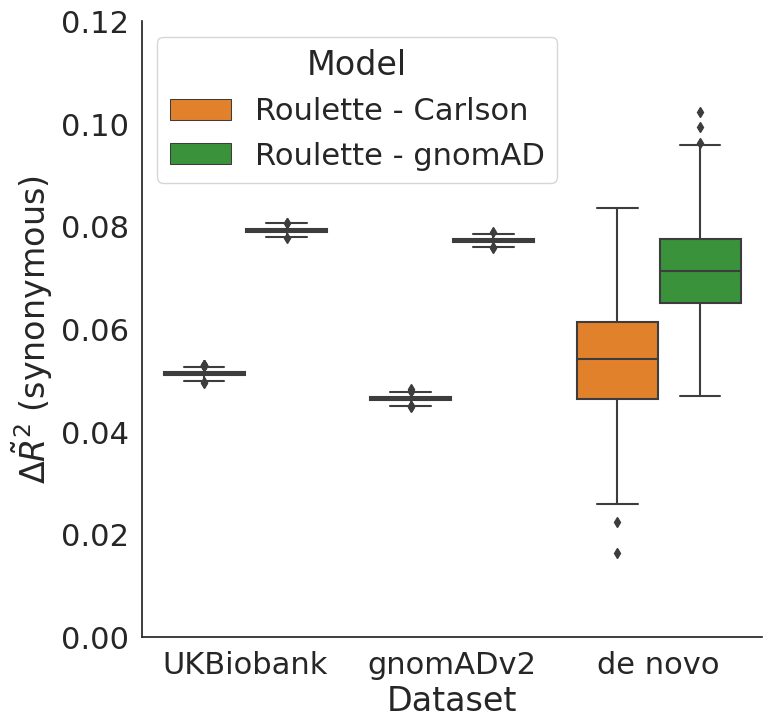

In [65]:
plt.subplots(figsize=(8, 8))

col = np.array(sns.color_palette())[1:]

ax = sns.boxplot(df_melt_combined, y="pR2 difference", x="Dataset", hue="Model", palette = col)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0.0, 0.12)

ax.set_ylabel(r"$\Delta \tilde{R}^2$ (synonymous)")
plt.savefig('2b.pdf', bbox_inches="tight")  